# Deep Reinforcement Learning for Portfolio optimization: Multi-Agent Trading Strategy


* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
''''!pip uninstall wrds
!pip uninstall swig
!pip uninstall -q condacolab

#import condacolab
#condacolab.install()'''
''''!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git'''

"'!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig\n!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git"


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2023-04-19'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()
df.to_csv('datasets.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832630,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.308595,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579329,7117200,CAT,4


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
105336,2023-04-18,503.670013,506.989990,498.140015,504.480011,3232000,UNH,1
105337,2023-04-18,233.750000,234.330002,231.690002,233.600006,4796200,V,1
105338,2023-04-18,39.470001,39.490002,38.900002,38.939999,16588500,VZ,1
105339,2023-04-18,36.049999,36.049999,35.389999,35.580002,4850800,WBA,1
105340,2023-04-18,149.779999,150.339996,149.440002,149.850006,4494100,WMT,1


In [9]:
df.shape

(105341, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758535,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832630,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.308595,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579329,7117200,CAT,4


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

AAPL    3597
AMGN    3597
WMT     3597
WBA     3597
VZ      3597
V       3597
UNH     3597
TRV     3597
PG      3597
NKE     3597
MSFT    3597
MRK     3597
MMM     3597
MCD     3597
KO      3597
JPM     3597
JNJ     3597
INTC    3597
IBM     3597
HON     3597
HD      3597
GS      3597
DIS     3597
CVX     3597
CSCO    3597
CRM     3597
CAT     3597
BA      3597
AXP     3597
DOW     1028
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [13]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30',
#                 'boll_up, boll_dn, close_30_sma, close_60_sma']   8 technical indicators were used + turbulence index 

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [15]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
1199,2009-03-04,18.990000,19.370001,18.700001,13.384529,22093200,HD,2,-0.478945,16.652504,12.686440,38.728648,-141.148301,34.944024,14.962603,15.420154,0.000000
85594,2020-09-23,94.779999,95.349998,92.660004,85.584923,19952700,JPM,2,-1.053476,97.162675,86.798756,43.479064,-228.363782,18.684791,92.068232,90.796275,84.432557
19307,2011-08-23,61.950001,63.220001,61.759998,44.820904,15222400,PG,1,-0.199404,44.893621,41.884823,51.656126,23.702190,0.313537,44.097442,44.806622,74.703650
81531,2020-03-05,124.760994,126.472275,122.801147,106.555473,5696725,IBM,3,-2.685852,135.296366,103.058880,41.961126,-126.770882,28.938243,118.293333,114.319491,67.570637
75430,2019-05-06,175.490005,177.240005,173.880005,157.059296,2735000,AMGN,0,-2.908334,174.857785,150.538660,41.190519,-106.703462,52.095071,164.753196,165.598274,23.762423


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [19]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [20]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  177.85724608715643
======Model training from:  2009-01-01 to  2020-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 87          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -0.245      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 29.8        |
|    reward             | -0.15770726 |
|    std                | 1           |
|    value_loss         | 1.55        |
---------------------------------------
--------------------------------------
| time/                 |        

-------------------------------------
| time/                 |           |
|    fps                | 81        |
|    iterations         | 1400      |
|    time_elapsed       | 86        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -41.4     |
|    explained_variance | -0.0156   |
|    learning_rate      | 0.0007    |
|    n_updates          | 1399      |
|    policy_loss        | 344       |
|    reward             | 0.6473981 |
|    std                | 1.01      |
|    value_loss         | 78        |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 80          |
|    iterations         | 1500        |
|    time_elapsed       | 92          |
|    total_timesteps    | 7500        |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | -0.00265    |
|    learning_rate      | 0.0007

======PPO Validation from:  2020-01-02 to  2020-04-02
PPO Sharpe Ratio:  -0.4208855421172371
======DDPG Training========
{'buffer_size': 10000, 'learning_rate': 0.0005, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg\ddpg_126_1
day: 2767, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5152446.39
total_reward: 4152446.39
total_cost: 1296.44
total_trades: 36019
Sharpe: 0.948
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 40       |
|    time_elapsed    | 271      |
|    total_timesteps | 11072    |
| train/             |          |
|    actor_loss      | -20.1    |
|    critic_loss     | 105      |
|    learning_rate   | 0.0005   |
|    n_updates       | 8304     |
|    reward          | 1.407809 |
---------------------------------
======DDPG Validation from:  2020-01-02 to  2020-04-02
======Best Model Retraining from:  2009-01-01 to  2020-04-02
======Trading from:  2020-04-02 to 

--------------------------------------
| time/                 |            |
|    fps                | 77         |
|    iterations         | 1300       |
|    time_elapsed       | 84         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 1299       |
|    policy_loss        | -66.8      |
|    reward             | 0.09113873 |
|    std                | 1.01       |
|    value_loss         | 3.39       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 77        |
|    iterations         | 1400      |
|    time_elapsed       | 90        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -41.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 5           |
|    time_elapsed         | 104         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.014215397 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | -0.0228     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.87        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0257     |
|    reward               | 1.2533604   |
|    std                  | 1.01        |
|    value_loss           | 20.6        |
-----------------------------------------
======PPO Validation from:  2020-04-02 to  2020-07-02
PPO Sharpe Ratio:  0.23529562906855347
======DDPG Training========
{'buffer_size': 10000, 'learning_rate':

-------------------------------------
| time/                 |           |
|    fps                | 53        |
|    iterations         | 1100      |
|    time_elapsed       | 103       |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -41       |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1099      |
|    policy_loss        | 81.1      |
|    reward             | -6.359173 |
|    std                | 0.994     |
|    value_loss         | 8.56      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 53         |
|    iterations         | 1200       |
|    time_elapsed       | 111        |
|    total_timesteps    | 6000       |
| train/                |            |
|    entropy_loss       | -41        |
|    explained_variance | 0.0406     |
|    learning_rate      | 0.0007     |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 80          |
|    iterations           | 4           |
|    time_elapsed         | 101         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016306706 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.3       |
|    explained_variance   | -0.00628    |
|    learning_rate        | 0.00025     |
|    loss                 | 68.7        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0167     |
|    reward               | -1.3102336  |
|    std                  | 1.01        |
|    value_loss           | 124         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 5     

-------------------------------------
| time/                 |           |
|    fps                | 55        |
|    iterations         | 1000      |
|    time_elapsed       | 89        |
|    total_timesteps    | 5000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 999       |
|    policy_loss        | 34.4      |
|    reward             | 2.9443834 |
|    std                | 1         |
|    value_loss         | 1.09      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 54        |
|    iterations         | 1100      |
|    time_elapsed       | 100       |
|    total_timesteps    | 5500      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

-----------------------------------------
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 3           |
|    time_elapsed         | 77          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.018642673 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0314     |
|    learning_rate        | 0.00025     |
|    loss                 | 12.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0226     |
|    reward               | 1.1542779   |
|    std                  | 1           |
|    value_loss           | 31          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 4     

------------------------------------
| time/                 |          |
|    fps                | 54       |
|    iterations         | 800      |
|    time_elapsed       | 73       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -41.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | -81.7    |
|    reward             | 1.458235 |
|    std                | 0.998    |
|    value_loss         | 5.07     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 54        |
|    iterations         | 900       |
|    time_elapsed       | 83        |
|    total_timesteps    | 4500      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 89

Logging to tensorboard_log/ppo\ppo_378_1
------------------------------------
| time/              |             |
|    fps             | 82          |
|    iterations      | 1           |
|    time_elapsed    | 24          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.08434318 |
------------------------------------
day: 3019, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 4711191.38
total_reward: 3711191.38
total_cost: 375733.11
total_trades: 84692
Sharpe: 0.872
-----------------------------------------
| time/                   |             |
|    fps                  | 83          |
|    iterations           | 2           |
|    time_elapsed         | 48          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020187795 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|  

--------------------------------------
| time/                 |            |
|    fps                | 70         |
|    iterations         | 600        |
|    time_elapsed       | 42         |
|    total_timesteps    | 3000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 599        |
|    policy_loss        | 137        |
|    reward             | -3.0951073 |
|    std                | 1          |
|    value_loss         | 51.6       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 70        |
|    iterations         | 700       |
|    time_elapsed       | 49        |
|    total_timesteps    | 3500      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

------------------------------------
| time/                 |          |
|    fps                | 71       |
|    iterations         | 2000     |
|    time_elapsed       | 140      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1999     |
|    policy_loss        | -13.3    |
|    reward             | 1.550728 |
|    std                | 1        |
|    value_loss         | 1.93     |
------------------------------------
======A2C Validation from:  2021-04-05 to  2021-07-02
A2C Sharpe Ratio:  0.07831101114131643
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_441_1
-----------------------------------
| time/              |            |
|    fps             | 93         |
|    iterations      | 1          |
|    

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 500        |
|    time_elapsed       | 36         |
|    total_timesteps    | 2500       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 499        |
|    policy_loss        | 663        |
|    reward             | -14.944909 |
|    std                | 1          |
|    value_loss         | 433        |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 68        |
|    iterations         | 600       |
|    time_elapsed       | 43        |
|    total_timesteps    | 3000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.00599  |
|    learning_rate      | 0.0007  

-------------------------------------
| time/                 |           |
|    fps                | 68        |
|    iterations         | 1900      |
|    time_elapsed       | 138       |
|    total_timesteps    | 9500      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1899      |
|    policy_loss        | 179       |
|    reward             | 3.2930667 |
|    std                | 1.01      |
|    value_loss         | 32.4      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 68          |
|    iterations         | 2000        |
|    time_elapsed       | 146         |
|    total_timesteps    | 10000       |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 3.04e-06    |
|    learning_rate      | 0.0007

-------------------------------------
| time/                 |           |
|    fps                | 65        |
|    iterations         | 400       |
|    time_elapsed       | 30        |
|    total_timesteps    | 2000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 399       |
|    policy_loss        | -67.1     |
|    reward             | 1.0544771 |
|    std                | 1         |
|    value_loss         | 7.21      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 65         |
|    iterations         | 500        |
|    time_elapsed       | 37         |
|    total_timesteps    | 2500       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0.161      |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 68        |
|    iterations         | 1800      |
|    time_elapsed       | 130       |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -41.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1799      |
|    policy_loss        | 312       |
|    reward             | 0.5129049 |
|    std                | 1.01      |
|    value_loss         | 54.9      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 68       |
|    iterations         | 1900     |
|    time_elapsed       | 137      |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | -0.00253 |
|    learning_rate      | 0.0007   |
|    n_updates        

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 300      |
|    time_elapsed       | 21       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 299      |
|    policy_loss        | -187     |
|    reward             | 5.57107  |
|    std                | 1        |
|    value_loss         | 22.4     |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 400        |
|    time_elapsed       | 28         |
|    total_timesteps    | 2000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates    

-------------------------------------
| time/                 |           |
|    fps                | 67        |
|    iterations         | 1700      |
|    time_elapsed       | 125       |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -76.8     |
|    reward             | 2.8505902 |
|    std                | 1         |
|    value_loss         | 5.47      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 1800       |
|    time_elapsed       | 132        |
|    total_timesteps    | 9000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.0575    |
|    learning_rate      | 0.0007     |
| 

--------------------------------------
| time/                 |            |
|    fps                | 65         |
|    iterations         | 200        |
|    time_elapsed       | 15         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0.0273     |
|    learning_rate      | 0.0007     |
|    n_updates          | 199        |
|    policy_loss        | 29.1       |
|    reward             | -1.6023889 |
|    std                | 1          |
|    value_loss         | 1.03       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 65        |
|    iterations         | 300       |
|    time_elapsed       | 22        |
|    total_timesteps    | 1500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

------------------------------------
| time/                 |          |
|    fps                | 67       |
|    iterations         | 1600     |
|    time_elapsed       | 117      |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1599     |
|    policy_loss        | 80.4     |
|    reward             | 2.8612   |
|    std                | 1        |
|    value_loss         | 7.12     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 67        |
|    iterations         | 1700      |
|    time_elapsed       | 125       |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 16

--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.0622    |
|    learning_rate      | 0.0007     |
|    n_updates          | 199        |
|    policy_loss        | 11         |
|    reward             | -0.5706221 |
|    std                | 1          |
|    value_loss         | 1.64       |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 67       |
|    iterations         | 300      |
|    time_elapsed       | 22       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | -0.0118  |
|    learning_rate      | 0.0007   |
|    n

-------------------------------------
| time/                 |           |
|    fps                | 66        |
|    iterations         | 1600      |
|    time_elapsed       | 120       |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0.0322    |
|    learning_rate      | 0.0007    |
|    n_updates          | 1599      |
|    policy_loss        | -160      |
|    reward             | -1.738011 |
|    std                | 1.01      |
|    value_loss         | 18.8      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 65        |
|    iterations         | 1700      |
|    time_elapsed       | 129       |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0.00752   |
|    learning_rate      | 0.0007    |
|    n_updat

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 199        |
|    policy_loss        | -48.9      |
|    reward             | 0.69354594 |
|    std                | 1          |
|    value_loss         | 2.34       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 67        |
|    iterations         | 300       |
|    time_elapsed       | 22        |
|    total_timesteps    | 1500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | -0.0988   |
|    learning_rate      | 0.0007  

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 1600       |
|    time_elapsed       | 118        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | -0.0453    |
|    learning_rate      | 0.0007     |
|    n_updates          | 1599       |
|    policy_loss        | 121        |
|    reward             | -2.9921424 |
|    std                | 0.998      |
|    value_loss         | 9.74       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 67        |
|    iterations         | 1700      |
|    time_elapsed       | 126       |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

In [21]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-01-02,2020-04-02,PPO,-0.436593,-0.420886,-0.448258
1,189,2020-04-02,2020-07-02,DDPG,0.246415,0.235296,0.253032
2,252,2020-07-02,2020-10-01,PPO,0.172898,0.290354,0.195547
3,315,2020-10-01,2020-12-31,DDPG,0.19464,0.203547,0.207601
4,378,2020-12-31,2021-04-05,DDPG,0.299691,0.317186,0.359687
5,441,2021-04-05,2021-07-02,DDPG,0.078311,-0.006699,0.269419
6,504,2021-07-02,2021-10-01,DDPG,-0.204899,-0.081186,0.001313
7,567,2021-10-01,2021-12-31,PPO,0.112816,0.191458,0.188399
8,630,2021-12-31,2022-04-01,A2C,-0.102228,-0.191814,-0.119514
9,693,2022-04-01,2022-07-05,DDPG,-0.231171,-0.21332,-0.203779


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [23]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.610365724928477


In [24]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2020-04-02,NaN,2020-04-02
1,9.987116e+05,2020-04-03,-0.001288,2020-04-03
2,1.010130e+06,2020-04-06,0.011433,2020-04-06
3,1.011234e+06,2020-04-07,0.001093,2020-04-07
4,1.017094e+06,2020-04-08,0.005795,2020-04-08


<AxesSubplot:>

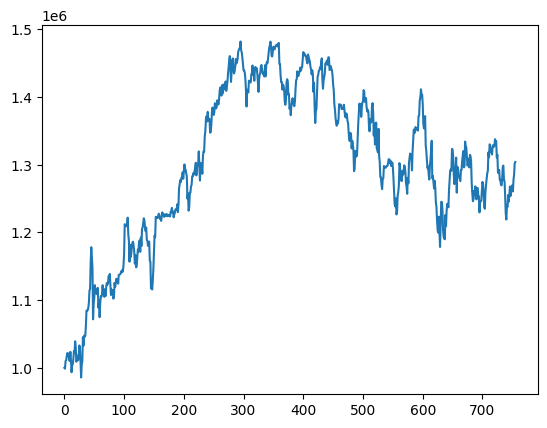

In [25]:
%matplotlib inline
df_account_value.account_value.plot()

In [26]:
df_a2c_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('A2C',i))
    df_a2c_value = df_a2c_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_a2c_value=df_a2c_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.26908507256048114


<AxesSubplot:>

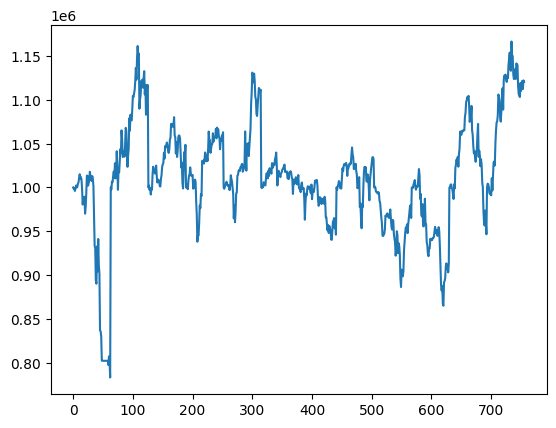

In [27]:
%matplotlib inline
df_a2c_value.account_value.plot()

In [28]:
df_ppo_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('PPO',i))
    df_ppo_value = df_ppo_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ppo_value=df_ppo_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.26908507256048114


<AxesSubplot:>

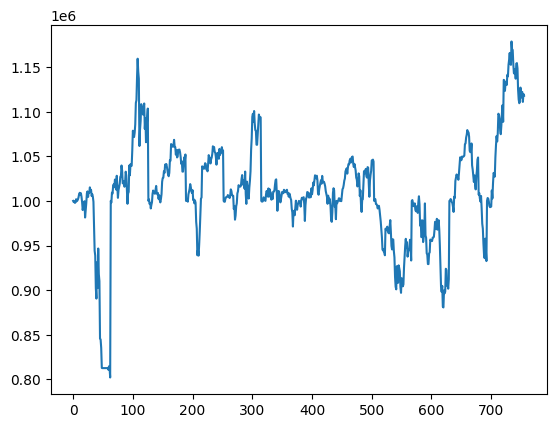

In [29]:
%matplotlib inline
df_ppo_value.account_value.plot()

In [30]:
df_ddpg_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('DDPG',i))
    df_ddpg_value = df_ddpg_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_ddpg_value.account_value.pct_change(1).mean()/df_ddpg_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ddpg_value=df_ddpg_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.24176792030801125


<AxesSubplot:>

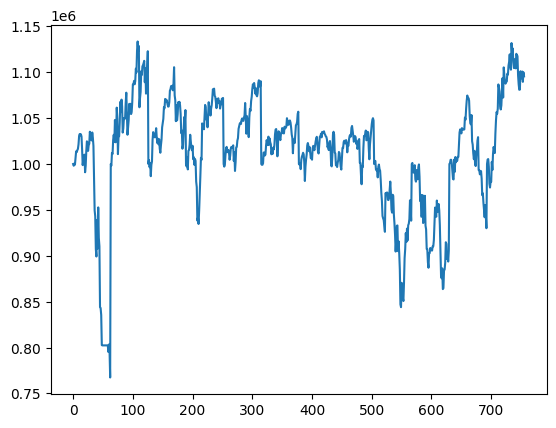

In [31]:
%matplotlib inline
df_ddpg_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
print("======================Ensemble=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================Ensemble=======================
Annual return          0.092514
Cumulative returns     0.304010
Annual volatility      0.168468
Sharpe ratio           0.610366
Calmar ratio           0.451679
Stability              0.203578
Max drawdown          -0.204823
Omega ratio            1.112257
Sortino ratio          0.859603
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.054996
Daily value at risk   -0.020817
dtype: float64


In [33]:
print("==============Get Backtest Results===========")
print("======================A2C=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_a2c_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================A2C=======================
Annual return          0.038636
Cumulative returns     0.120444
Annual volatility      0.271163
Sharpe ratio           0.269085
Calmar ratio           0.151542
Stability              0.006674
Max drawdown          -0.254952
Omega ratio            1.066247
Sortino ratio          0.442675
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.894979
Daily value at risk   -0.033874
dtype: float64


In [34]:
print("==============Get Backtest Results===========")
print("======================PPO=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ppo_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================PPO=======================
Annual return          0.037856
Cumulative returns     0.117922
Annual volatility      0.250557
Sharpe ratio           0.268427
Calmar ratio           0.157450
Stability              0.013896
Max drawdown          -0.240433
Omega ratio            1.068180
Sortino ratio          0.446334
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.996221
Daily value at risk   -0.031300
dtype: float64


In [35]:
print("==============Get Backtest Results===========")
print("======================DDPG=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ddpg_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================DDPG=======================
Annual return          0.030869
Cumulative returns     0.095496
Annual volatility      0.289696
Sharpe ratio           0.241768
Calmar ratio           0.119364
Stability              0.004569
Max drawdown          -0.258615
Omega ratio            1.059947
Sortino ratio          0.403357
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.906846
Daily value at risk   -0.036220
dtype: float64


In [36]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (755, 8)
Annual return          0.158488
Cumulative returns     0.553891
Annual volatility      0.183703
Sharpe ratio           0.893840
Calmar ratio           0.722341
Stability              0.388506
Max drawdown          -0.219408
Omega ratio            1.167670
Sortino ratio          1.307070
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014967
Daily value at risk   -0.022493
dtype: float64


In [37]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2020-04-02  1.000000e+06
1    2020-04-03  9.831456e+05
2    2020-04-06  1.059147e+06
3    2020-04-07  1.057927e+06
4    2020-04-08  1.094339e+06
..          ...           ...
751  2023-03-28  1.512800e+06
752  2023-03-29  1.527900e+06
753  2023-03-30  1.534505e+06
754  2023-03-31  1.553891e+06
755  2023-04-03           NaN

[756 rows x 2 columns]
df_dji:                       dji
date                    
2020-04-02  1.000000e+06
2020-04-03  9.831456e+05
2020-04-06  1.059147e+06
2020-04-07  1.057927e+06
2020-04-08  1.094339e+06
...                  ...
2023-03-28  1.512800e+06
2023-03-29  1.527900e+06
2023-03-30  1.534505e+06
2023-03-31  1.553891e+06
2023-04-03           NaN

[756 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_result_a2c.columns:  Index(['a2c'], dtype='object')
df_result_ppo.columns:  Index(['ppo'], dtype='object')
df_result_ddpg.columns:  Index(['ddpg'], dtype='object')
df_trade_date:         datadate
0    2020-01-02
1    2020-01-03
2    2020-01-06
3    2020-01-07
4    2020-01-08
..          ...
824  2023-04-12
825  2023-04-13
826  2023-04-14
827  2023-04-17
828  2023-04-18

[829 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2020-04-02  1.000000e+06
2020-04-03  9.987116e+05
2020-04-06  1.010130e+06
2020-04-07  1.011234e+06
2020-04-08  1.017094e+06
...                  ...
2023-03-28  1.260490e+06
2023-03-29  1.277696e+06
2023-03-30  1.285622e+06
2023-03-31  1.302168e+06
2023-04-03  1.304010e+06

[756 rows x 1 columns]
df_result_a2c:                       a2c
date                    
2020-01-02  1.000000e+06
2020-01-03  9.984620e+05
2020-01-06  9.989386e+05
2020-01-07  9.959984e+05


<Figure size 2000x1000 with 0 Axes>

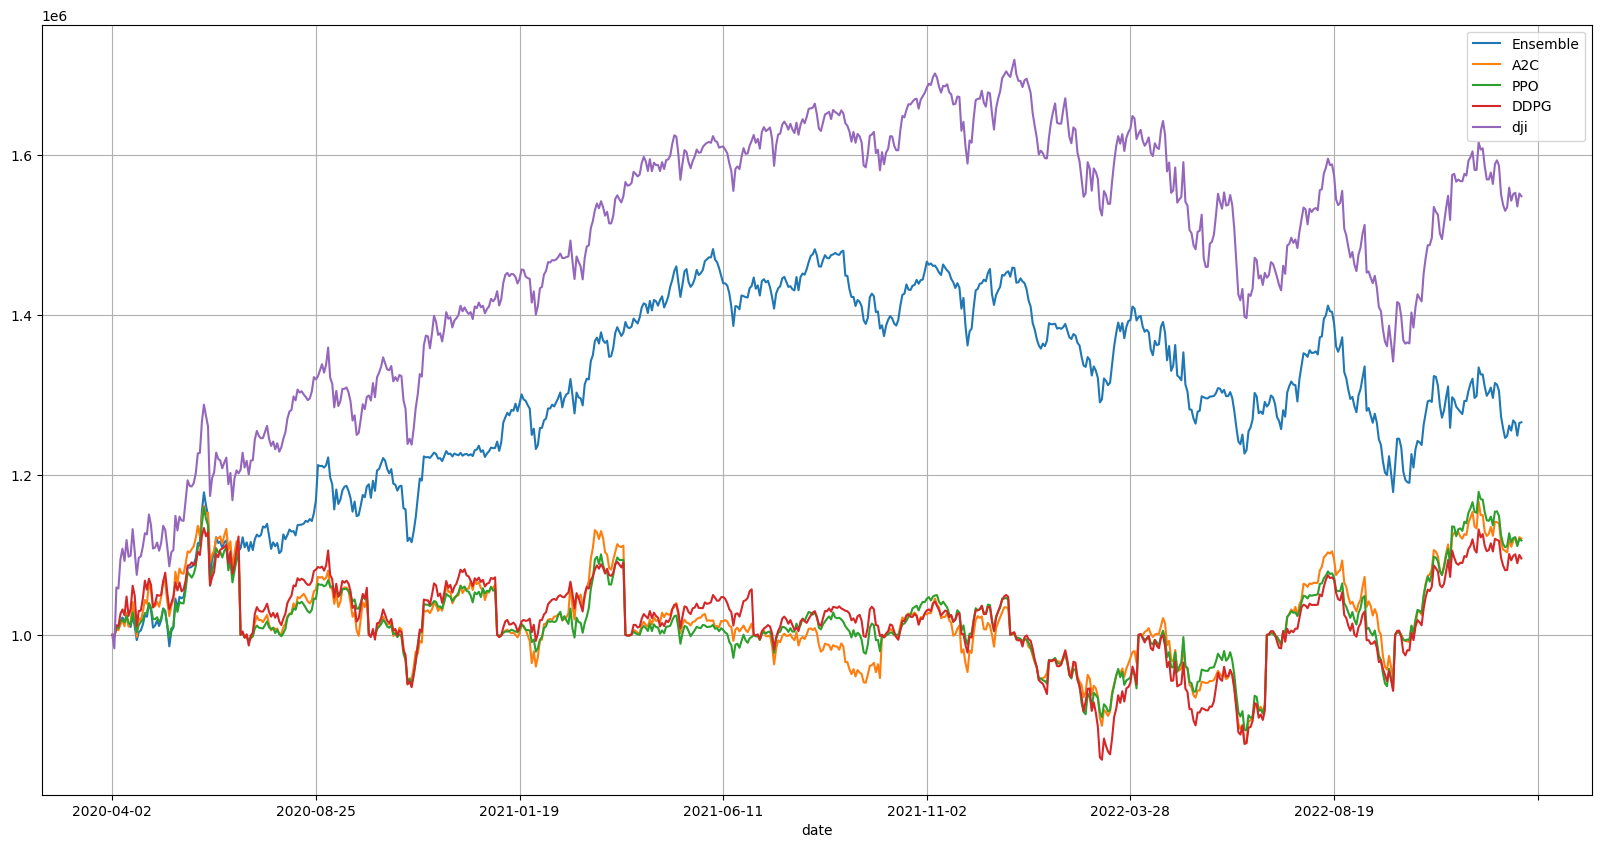

In [38]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#               baseline_ticker = '^DJI', 
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_a2c = pd.DataFrame({'date': df_a2c_value['date'], 'a2c': df_a2c_value['account_value']})
df_result_a2c = df_result_a2c.set_index('date')

df_result_ppo = pd.DataFrame({'date': df_ppo_value['date'], 'ppo': df_ppo_value['account_value']})
df_result_ppo = df_result_ppo.set_index('date')

df_result_ddpg = pd.DataFrame({'date': df_ddpg_value['date'], 'ddpg': df_ddpg_value['account_value']})
df_result_ddpg = df_result_ddpg.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_result_a2c.columns: ", df_result_a2c.columns)
print("df_result_ppo.columns: ", df_result_ppo.columns)
print("df_result_ddpg.columns: ", df_result_ddpg.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
df_result_a2c.to_csv("df_result_a2c.csv")
df_result_ppo.to_csv("df_result_ppo.csv")
df_result_ddpg.to_csv("df_result_ddpg.csv")

print("df_result_ensemble: ", df_result_ensemble)
print("df_result_a2c: ", df_result_a2c)
print("df_result_ppo: ", df_result_ppo)
print("df_result_ddpg: ", df_result_ddpg)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_result_a2c, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_dji, left_index=True, right_index=True)

print("result: ", result)
result.to_csv("result.csv")
result.columns = ['Ensemble','A2C','PPO','DDPG', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.figure();

ax = result.plot()
ax.grid(True)

plt.show()

In [58]:
#EXTRACT TURBULENCE INDEX
turbulence_df = processed.groupby(['date'])['turbulence'].last().reset_index()
selected_df = turbulence_df[(turbulence_df['date'] >= '2020-04-02') & (turbulence_df['date'] <= '2020-05-01')]
selected_df = selected_df.set_index('date')


df_result_ensemble:                  ensemble
date                    
2020-04-02  1.000000e+06
2020-04-03  9.987116e+05
2020-04-06  1.010130e+06
2020-04-07  1.011234e+06
2020-04-08  1.017094e+06
...                  ...
2023-03-28  1.260490e+06
2023-03-29  1.277696e+06
2023-03-30  1.285622e+06
2023-03-31  1.302168e+06
2023-04-03  1.304010e+06

[756 rows x 1 columns]
df_result_a2c:                       a2c
date                    
2020-01-02  1.000000e+06
2020-01-03  9.984620e+05
2020-01-06  9.989386e+05
2020-01-07  9.959984e+05
2020-01-08  9.997995e+05
...                  ...
2022-12-23  1.117641e+06
2022-12-27  1.121476e+06
2022-12-28  1.112213e+06
2022-12-29  1.122049e+06
2022-12-30  1.120444e+06

[756 rows x 1 columns]
df_result_ppo:                       ppo
date                    
2020-01-02  1.000000e+06
2020-01-03  9.986714e+05
2020-01-06  9.994962e+05
2020-01-07  9.977681e+05
2020-01-08  9.984654e+05
...                  ...
2022-12-23  1.120998e+06
2022-12-27  1.122081e+06

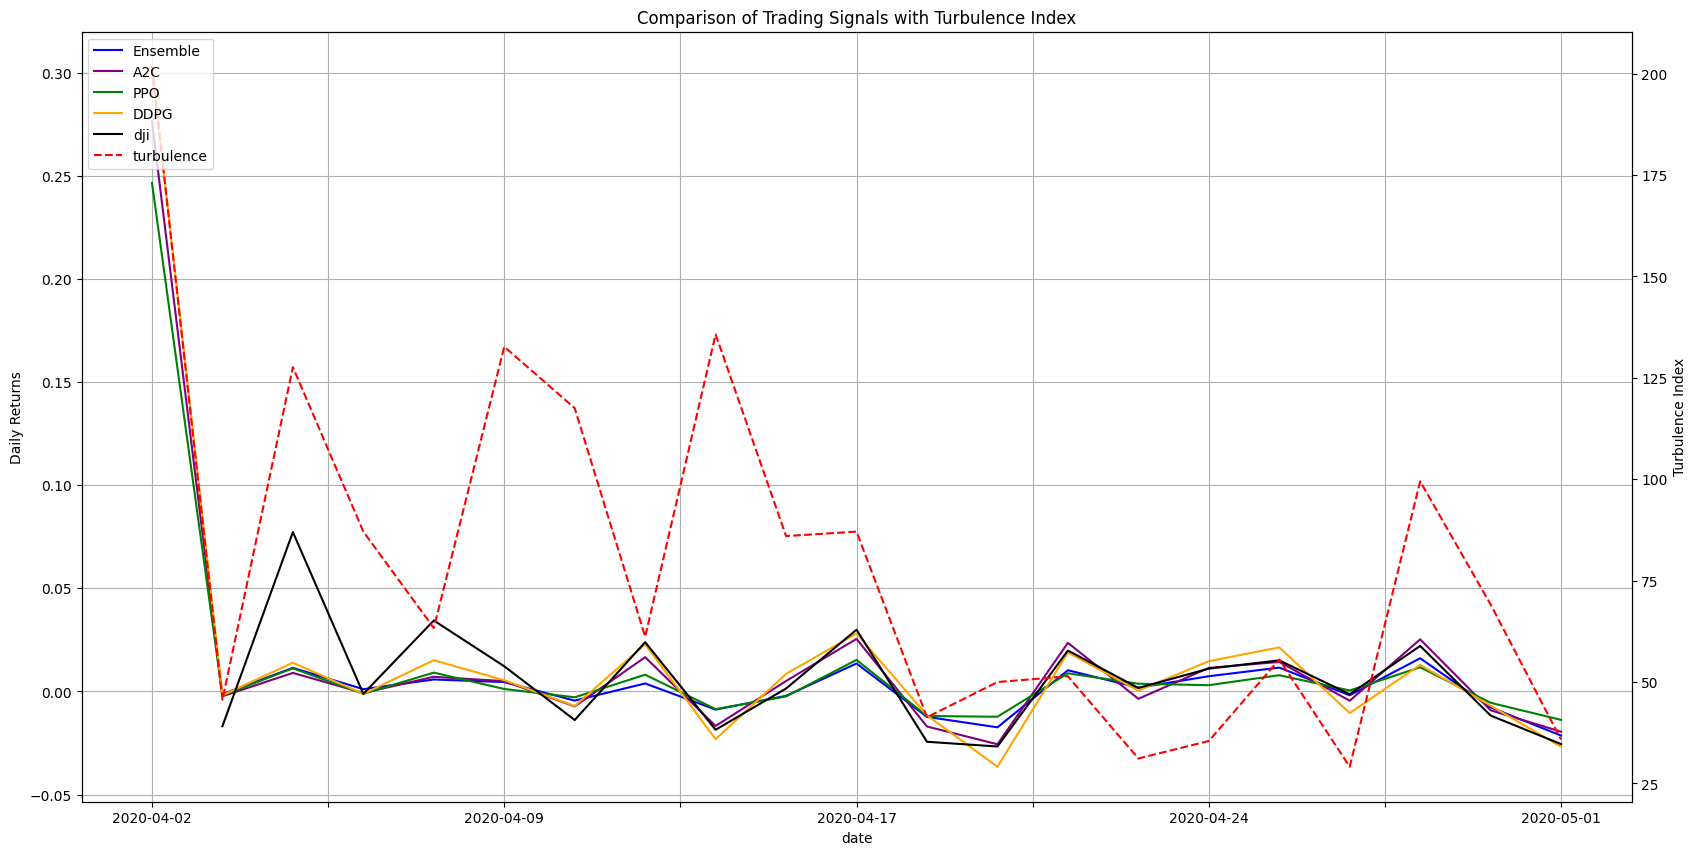

In [59]:
###############################DAILY RETURNS#######################################
print("df_result_ensemble: ", df_result_ensemble)
print("df_result_a2c: ", df_result_a2c)
print("df_result_ppo: ", df_result_ppo)
print("df_result_ddpg: ", df_result_ddpg)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble.pct_change(1), df_result_a2c.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg.pct_change(1), left_index=True, right_index=True)
result = pd.merge(result, df_dji.pct_change(1), left_index=True, right_index=True)

# results during market crash 2-01-2020 to 7-05-2020

print("result: ", result)

result.columns = ['Ensemble','A2C','PPO','DDPG', 'dji']

import matplotlib.pyplot as plt
result = result.loc['2020-04-02':'2020-05-01']

# create a figure with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot the daily returns of each signal on the left y-axis
result['Ensemble'].plot(ax=ax1, color='blue')
result['A2C'].plot(ax=ax1, color='purple')
result['PPO'].plot(ax=ax1, color='green')
result['DDPG'].plot(ax=ax1, color='orange')
result['dji'].plot(ax=ax1, color='black')
selected_df['turbulence'].plot(ax=ax2, color='red', linestyle='--')


# set the y-axis labels and title
ax1.set_ylabel('Daily Returns')
ax2.set_ylabel('Turbulence Index')
ax1.grid(True)
plt.title('Comparison of Trading Signals with Turbulence Index')

# add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.show()






In [49]:
len(selected_df)

108

In [45]:
len(result['Ensemble'])

63

In [57]:
result['Ensemble']


date
2020-04-02         NaN
2020-04-03   -0.001288
2020-04-06    0.011433
2020-04-07    0.001093
2020-04-08    0.005795
2020-04-09    0.004543
2020-04-13   -0.004448
2020-04-14    0.003863
2020-04-15   -0.008796
2020-04-16   -0.002145
2020-04-17    0.013564
2020-04-20   -0.012339
2020-04-21   -0.017403
2020-04-22    0.010283
2020-04-23    0.001831
2020-04-24    0.007373
2020-04-27    0.011560
2020-04-28   -0.001861
2020-04-29    0.016096
2020-04-30   -0.007742
2020-05-01   -0.021406
Name: Ensemble, dtype: float64

In [56]:
selected_df

,turbulence
date,
2020-01-02,23.272816
2020-01-03,6.643269
2020-01-06,24.932423
2020-01-07,34.986297
2020-01-08,42.003051
...,...
2020-04-27,55.566349
2020-04-28,29.121758
2020-04-29,99.482479
